<a href="https://colab.research.google.com/github/divyakumar-cloud/Divya/blob/master/FMADDPG_Privacy_Preservation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ==============================================================================
 # NOTEBOOK 1: Environment_Setup.ipynb
 # ==============================================================================
 # Cell 1: Mount Drive and Create Directory Structure
from google.colab import drive
import os
import sys
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
 # Mount Google Drive
drive.mount('/content/drive')
 # Create comprehensive project structure
base_path = '/content/drive/MyDrive/FMARL_IoT_Research'
# List of directories to create
directories = [
    'src/core', 'src/agents', 'src/privacy', 'src/federated',
    'src/evaluation', 'src/utils', 'data/synthetic', 'data/real',
    'models/checkpoints', 'models/trained', 'results/experiments',
    'results/figures', 'papers/drafts', 'papers/final',
    'notebooks/development', 'notebooks/experiments'
]
 # Create directories if they don't exist
for dir_path in directories:
    os.makedirs(os.path.join(base_path, dir_path), exist_ok=True)
 # Add src folder to Python path
sys.path.append(os.path.join(base_path, 'src'))

print("✅ Directory structure created successfully!")
print(f" Base path: {base_path}")


Mounted at /content/drive
✅ Directory structure created successfully!
 Base path: /content/drive/MyDrive/FMARL_IoT_Research


In [3]:
# Cell 2: Install All Required Libraries with version fixes for dependency conflicts
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q stable-baselines3[extra] gymnasium
!pip install -q tenseal diffprivlib cryptography==44.0.3
!pip install --upgrade pydrive2 pyopenssl
!pip install -q protobuf>=5.29.1
!pip install -q flwr ray[default]
!pip install -q pandas numpy scipy matplotlib seaborn plotly
!pip install -q networkx simpy faker
!pip install -q tqdm psutil memory-profiler
!pip install -q wandb tensorboard
!pip install -q scikit-learn umap-learn

# Verify installations
import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 13.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyopenssl 24.2.1 requires cryptography<44,>=41.0.5, but you have cryptography 44.0.3 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 44.0.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 69.8 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 44.0.3
    Uninstalling cryptography-44.0.3:
      Successfully uninstalled cryptography-44.0.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.

In [4]:
# Cell 3: Session Management System
import pickle
import json
import gc
import time
import torch
import psutil
from typing import Dict, List, Any, Optional
# Define base_path if not already defined
base_path = '/content/drive/MyDrive/FMARL_IoT_Research'
class UniversalSessionManager:
    def __init__(self, base_path: str):
        self.base_path = base_path
        self.session_start = time.time()
        self.checkpoints = {}

    def save_checkpoint(self, name: str, data: Any):
        """Save checkpoint with automatic timestamping"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{name}_{timestamp}.pkl"
        filepath = f"{self.base_path}/models/checkpoints/{filename}"

        with open(filepath, 'wb') as f:
            pickle.dump({
                'data': data,
                'timestamp': timestamp,
                'session_duration': time.time() - self.session_start
            }, f)

        self.checkpoints[name] = filepath
        print(f" Checkpoint saved: {filename}")
        return filepath

    def load_checkpoint(self, name: str, latest: bool = True):
        """Load checkpoint by name"""
        if latest:
            import glob
            pattern = f"{self.base_path}/models/checkpoints/{name}_*.pkl"
            files = glob.glob(pattern)
            if files:
                filepath = max(files, key=os.path.getctime)
                with open(filepath, 'rb') as f:
                    # Load data using pickle
                    loaded_data = pickle.load(f)['data']

                    # Recursively move any torch tensors/modules to CPU
                    def move_to_cpu(obj):
                        if isinstance(obj, torch.Tensor):
                            return obj.cpu()
                        elif isinstance(obj, dict):
                            return {k: move_to_cpu(v) for k, v in obj.items()}
                        elif isinstance(obj, list):
                            return [move_to_cpu(item) for item in obj]
                        elif isinstance(obj, tuple):
                            return tuple(move_to_cpu(item) for item in obj)
                        elif isinstance(obj, torch.nn.Module):
                            return obj.to(torch.device('cpu'))
                        else:
                            return obj

                    return move_to_cpu(loaded_data)
        return None


    def optimize_memory(self):
        """Optimize memory usage"""
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

        # Memory status
        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated() / 1024**3
            reserved = torch.cuda.memory_reserved() / 1024**3
            print(f" GPU Memory: {allocated:.2f}GB allocated, {reserved:.2f}GB reserved")
 # Initialize session manager
session_manager = UniversalSessionManager(base_path)
print("✅ Session manager initialized!")
 # Cell 4: Configuration Management
class ResearchConfig:
    def __init__(self):
        self.configs = {
            'development': {
                'name': 'Development Config',
                'max_agents': 15,
                'max_episodes': 200,
                'network_hidden': [128, 64],
                'batch_size': 32,
                'replay_buffer_size': 20000,
                'lr_actor': 1e-4,
                'lr_critic': 1e-3,
                'privacy_epsilon': 1.0,
                'description': 'For rapid development and debugging'
            },
            'validation': {
                'name': 'Validation Config',
                'max_agents': 30,
                'max_episodes': 500,
                'network_hidden': [256, 128],
                'batch_size': 64,
                'replay_buffer_size': 50000,
                'lr_actor': 5e-5,
                'lr_critic': 1e-3,
                'privacy_epsilon': 0.5,
                'description': 'For validation experiments'
            },
            'publication': {
                'name': 'Publication Config',
                'max_agents': 100,
                'max_episodes': 1000,
                'network_hidden': [512, 256],
                'batch_size': 128,
                'replay_buffer_size': 100000,
                'lr_actor': 1e-5,
                'lr_critic': 5e-4,
                'privacy_epsilon': 0.1,
                'description': 'For publication-quality results'
            }
        }

    def get(self, config_name: str = 'development'):
        return self.configs[config_name]

    def auto_select(self):
        """Auto-select based on available resources"""
        import psutil
        ram_gb = psutil.virtual_memory().total / (1024**3)

        if ram_gb > 25:  # Colab Pro
            return self.get('publication')
        elif ram_gb > 15:  # Standard Colab
            return self.get('validation')
        else:
            return self.get('development')
config = ResearchConfig()
current_config = config.auto_select()
print(f"✅ Auto-selected config: {current_config['name']}")
print(f"   Max agents: {current_config['max_agents']}")

✅ Session manager initialized!
✅ Auto-selected config: Development Config
   Max agents: 15


In [5]:
# ==============================================================================
 # NOTEBOOK 2: IoT_Simulation_Framework.ipynb
# ==============================================================================
 # Cell 1: Universal IoT Device Abstraction
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, List, Tuple, Any
from enum import Enum
import random
class SensorBehaviorType(Enum):
    CONTINUOUS_HIGH_FREQ = "continuous_hf"  # Like accelerometer, audio
    CONTINUOUS_LOW_FREQ = "continuous_lf"   # Like temperature, pressure
    DISCRETE_EVENT = "discrete_event"        # Like motion detection
    BINARY_THRESHOLD = "binary_threshold"    # Like proximity sensors
@dataclass
class SensorConfiguration:
    behavior_type: SensorBehaviorType
    sampling_rate: float  # Hz
    data_range: Tuple[float, float]
    noise_std: float
    drift_rate: float = 0.0
    correlation_factor: float = 0.0
class UniversalSensorSimulator:
    """Universal sensor simulator based on behavioral patterns"""

    def __init__(self, sensor_config: SensorConfiguration):
        self.config = sensor_config
        self.current_value = np.mean(sensor_config.data_range)
        self.drift_accumulator = 0.0
        self.time_step = 0

    def generate_sample(self, external_influence: float = 0.0) -> float:
        """Generate one sensor sample based on behavioral pattern"""

        if self.config.behavior_type == SensorBehaviorType.CONTINUOUS_HIGH_FREQ:
            # High frequency with temporal correlation
            base_signal = np.sin(2 * np.pi * self.time_step * 0.1) * 0.5
            noise = np.random.normal(0, self.config.noise_std)
            value = self.current_value + base_signal + noise + external_influence

        elif self.config.behavior_type == SensorBehaviorType.CONTINUOUS_LOW_FREQ:
            # Slow changes with drift
            drift = np.random.normal(0, self.config.drift_rate)
            self.drift_accumulator += drift
            noise = np.random.normal(0, self.config.noise_std)
            value = self.current_value + self.drift_accumulator + noise + external_influence

        elif self.config.behavior_type == SensorBehaviorType.DISCRETE_EVENT:
            # Event-driven with state changes
            if np.random.random() < 0.1:  # 10% chance of event
                value = np.random.choice([0, 1, 2, 3])  # Discrete states
            else:
                value = self.current_value  # Keep previous state

        elif self.config.behavior_type == SensorBehaviorType.BINARY_THRESHOLD:
            # Binary states with hysteresis
            threshold = np.mean(self.config.data_range)
            hysteresis = 0.1 * (self.config.data_range[1] - self.config.data_range[0])

            if self.current_value == 0 and external_influence > threshold + hysteresis:
                value = 1
            elif self.current_value == 1 and external_influence < threshold - hysteresis:
                value = 0
            else:
                value = self.current_value

        # Clip to range and update
        value = np.clip(value, *self.config.data_range)
        self.current_value = value
        self.time_step += 1

        return float(value)
class UniversalIoTDevice:
    """Universal IoT device with multiple sensors"""

    def __init__(self, device_id: str, sensor_configs: Dict[str, SensorConfiguration]):
        self.device_id = device_id
        self.sensors = {
            name: UniversalSensorSimulator(config)
            for name, config in sensor_configs.items()
        }
        self.location = np.random.uniform(-1, 1, 2)  # 2D location
        self.neighbors = []  # For network simulation

    def step(self, external_influences: Dict[str, float] = None) -> Dict[str, float]:
        """Generate one step of sensor data"""
        if external_influences is None:
            external_influences = {}

        readings = {}
        for sensor_name, sensor in self.sensors.items():
            influence = external_influences.get(sensor_name, 0.0)
            readings[sensor_name] = sensor.generate_sample(influence)

        return readings

    def get_behavioral_signature(self) -> Dict[str, str]:
        """Get behavioral signature of all sensors"""
        return {
            name: sensor.config.behavior_type.value
            for name, sensor in self.sensors.items()
        }

In [6]:
# Cell 2: IoT Network Simulation
import networkx as nx
from scipy.spatial.distance import euclidean

class IoTNetworkSimulator:
    """Simulates network topology and communication"""

    def __init__(self, num_devices: int, communication_range: float = 0.5):
        self.devices = {}
        self.network = nx.Graph()
        self.communication_range = communication_range
        self.create_network_topology(num_devices)

    def create_network_topology(self, num_devices: int):
        """Create realistic IoT network topology"""

        # Define sensor configurations for different behavioral patterns
        sensor_configs = {
            'pattern_1': {  # High-frequency continuous
                'accelerometer': SensorConfiguration(
                    SensorBehaviorType.CONTINUOUS_HIGH_FREQ, 100, (-10, 10), 0.1
                ),
                'proximity': SensorConfiguration(
                    SensorBehaviorType.BINARY_THRESHOLD, 10, (0, 1), 0.05
                )
            },
            'pattern_2': {  # Low-frequency continuous
                'temperature': SensorConfiguration(
                    SensorBehaviorType.CONTINUOUS_LOW_FREQ, 1, (15, 35), 0.5
                ),
                'humidity': SensorConfiguration(
                    SensorBehaviorType.CONTINUOUS_LOW_FREQ, 1, (30, 80), 2.0
                )
            },
            'pattern_3': {  # Event-driven
                'motion': SensorConfiguration(
                    SensorBehaviorType.DISCRETE_EVENT, 5, (0, 3), 0.1
                ),
                'sound_level': SensorConfiguration(
                    SensorBehaviorType.CONTINUOUS_HIGH_FREQ, 50, (30, 90), 5.0
                )
            }
        }

        # Create devices with mixed sensor patterns
        for i in range(num_devices):
            pattern_name = f'pattern_{(i % 3) + 1}'
            device = UniversalIoTDevice(f'device_{i}', sensor_configs[pattern_name])
            self.devices[f'device_{i}'] = device
            self.network.add_node(f'device_{i}', device=device)

        # Create edges based on communication range
        device_list = list(self.devices.values())
        for i, device1 in enumerate(device_list):
            for j, device2 in enumerate(device_list[i+1:], i+1):
                distance = euclidean(device1.location, device2.location)
                if distance <= self.communication_range:
                    self.network.add_edge(device1.device_id, device2.device_id,
                                        weight=distance)
                    device1.neighbors.append(device2.device_id)
                    device2.neighbors.append(device1.device_id)

    def simulate_step(self, global_influences: Dict[str, float] = None) -> Dict[str, Dict[str, float]]:
        """Simulate one time step for all devices"""
        if global_influences is None:
            global_influences = {}

        all_readings = {}
        for device_id, device in self.devices.items():
            readings = device.step(global_influences)
            all_readings[device_id] = readings

        return all_readings

    def get_network_stats(self) -> Dict[str, Any]:
        """Get network topology statistics"""
        return {
            'num_devices': len(self.devices),
            'num_connections': self.network.number_of_edges(),
            'avg_degree': np.mean([self.network.degree(node) for node in self.network.nodes()]),
            'clustering_coefficient': nx.average_clustering(self.network),
            'behavioral_patterns': self._count_behavioral_patterns()
        }

    def _count_behavioral_patterns(self) -> Dict[str, int]:
        """Count devices by behavioral patterns"""
        pattern_counts = {}
        for device in self.devices.values():
            signature = device.get_behavioral_signature()
            pattern_key = str(sorted(signature.values()))
            pattern_counts[pattern_key] = pattern_counts.get(pattern_key, 0) + 1
        return pattern_counts


In [7]:
 #Cell 3: Test Universal IoT Simulation
 # Create test network
 print("  Creating Universal IoT Network...")
 network = IoTNetworkSimulator(num_devices=15)
 print(f"✅ Network created with {len(network.devices)} devices")
 # Show network statistics
 stats = network.get_network_stats()
 print("\n Network Statistics:")
 for key, value in stats.items():
    print(f"   {key}: {value}")
 # Simulate data generation
 print("\n Simulating sensor data...")
 data_history = []
 for step in range(100):  # 100 time steps
    readings = network.simulate_step()
    data_history.append(readings)
    if step % 20 == 0:
        print(f"   Step {step}: Generated data for {len(readings)} devices")
 print("✅ IoT simulation framework ready!")

  Creating Universal IoT Network...
✅ Network created with 15 devices

 Network Statistics:
   num_devices: 15
   num_connections: 15
   avg_degree: 2.0
   clustering_coefficient: 0.2111111111111111
   behavioral_patterns: {"['binary_threshold', 'continuous_hf']": 5, "['continuous_lf', 'continuous_lf']": 5, "['continuous_hf', 'discrete_event']": 5}

 Simulating sensor data...
   Step 0: Generated data for 15 devices
   Step 20: Generated data for 15 devices
   Step 40: Generated data for 15 devices
   Step 60: Generated data for 15 devices
   Step 80: Generated data for 15 devices
✅ IoT simulation framework ready!


In [8]:
session_manager = UniversalSessionManager(base_path)
session_manager.save_checkpoint('iot_simulation', {
    'network': network,
    'data_history': data_history,
    'config': current_config
  })

 Checkpoint saved: iot_simulation_20250919_093819.pkl


'/content/drive/MyDrive/FMARL_IoT_Research/models/checkpoints/iot_simulation_20250919_093819.pkl'

In [9]:
# Cell 1: Neural Network Architectures
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import random
class BehavioralActorNetwork(nn.Module):
    """Actor network specialized for sensor behavioral patterns"""

    def __init__(self, state_dim: int, action_dim: int, hidden_dims: List[int],
                 behavior_type: SensorBehaviorType):
        super().__init__()
        self.behavior_type = behavior_type

        # Build network layers
        layers = []
        prev_dim = state_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),  # Better for RL
                nn.ReLU()
            ])
            prev_dim = hidden_dim

        # Behavioral-specific processing
        if behavior_type == SensorBehaviorType.CONTINUOUS_HIGH_FREQ:
            layers.append(nn.Dropout(0.1))  # Regularization for noisy signals
        elif behavior_type == SensorBehaviorType.DISCRETE_EVENT:
            layers.append(nn.Dropout(0.2))  # Higher dropout for sparse events

        layers.append(nn.Linear(prev_dim, action_dim))
        layers.append(nn.Tanh())  # Actions in [-1, 1]

        self.network = nn.Sequential(*layers)

        # Initialize weights based on behavioral pattern
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights based on behavioral pattern"""
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                if self.behavior_type == SensorBehaviorType.CONTINUOUS_HIGH_FREQ:
                    nn.init.xavier_uniform_(layer.weight, gain=0.5)  # Smaller weights
                else:
                    nn.init.xavier_uniform_(layer.weight, gain=1.0)
                nn.init.zeros_(layer.bias)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        return self.network(state)
class BehavioralCriticNetwork(nn.Module):
    """Critic network for value estimation"""

    def __init__(self, state_dim: int, action_dim: int, hidden_dims: List[int],
                 behavior_type: SensorBehaviorType):
        super().__init__()
        self.behavior_type = behavior_type

        # State processing branch
        self.state_branch = nn.Sequential(
            nn.Linear(state_dim, hidden_dims[0]),
            nn.LayerNorm(hidden_dims[0]),
            nn.ReLU()
        )

        # Combined state-action processing
        layers = []
        prev_dim = hidden_dims[0] + action_dim

        for hidden_dim in hidden_dims[1:]:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU()
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, 1))  # Single Q-value output
        self.q_network = nn.Sequential(*layers)

        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights"""
        for module in [self.state_branch, self.q_network]:
            for layer in module:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    nn.init.zeros_(layer.bias)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        state_features = self.state_branch(state)
        combined = torch.cat([state_features, action], dim=1)
        return self.q_network(combined)

In [10]:
 # Cell 2: Behavioral Experience Replay Buffer
Experience = namedtuple('Experience',
                       ['state', 'action', 'reward', 'next_state', 'done'])
class BehavioralReplayBuffer:
    """Experience replay buffer with behavioral pattern awareness"""

    def __init__(self, capacity: int, behavior_type: SensorBehaviorType):
        self.buffer = deque(maxlen=capacity)
        self.behavior_type = behavior_type

        # Behavioral-specific sampling weights
        self.priority_weights = {
            SensorBehaviorType.CONTINUOUS_HIGH_FREQ: 1.0,
            SensorBehaviorType.CONTINUOUS_LOW_FREQ: 1.2,  # Slightly prioritize
            SensorBehaviorType.DISCRETE_EVENT: 1.5,       # Higher priority for rare events
            SensorBehaviorType.BINARY_THRESHOLD: 1.1
        }

    def add(self, state, action, reward, next_state, done):
        """Add experience to buffer"""
        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> List[Experience]:
        """Sample batch of experiences"""
        if len(self.buffer) < batch_size:
            return list(self.buffer)

        # Behavioral-specific sampling strategy
        if self.behavior_type == SensorBehaviorType.DISCRETE_EVENT:
            # Prioritize non-zero reward experiences for event-driven sensors
            high_reward_experiences = [exp for exp in self.buffer if abs(exp.reward) > 0.1]
            if len(high_reward_experiences) >= batch_size // 2:
                sample_pool = high_reward_experiences + list(self.buffer)
            else:
                sample_pool = list(self.buffer)
        else:
            sample_pool = list(self.buffer)

        return random.sample(sample_pool, min(batch_size, len(sample_pool)))

    def __len__(self):
        return len(self.buffer)

In [11]:
#  Behavioral MADDPG Agent
class BehavioralMADDPGAgent:
    """MADDPG Agent specialized for sensor behavioral patterns"""

    def __init__(self, agent_id: str, state_dim: int, action_dim: int,
                 behavior_type: SensorBehaviorType, config: Dict):
        self.agent_id = agent_id
        self.behavior_type = behavior_type
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.config = config

        # Device selection
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Networks
        hidden_dims = config['network_hidden']
        self.actor = BehavioralActorNetwork(state_dim, action_dim, hidden_dims, behavior_type).to(self.device)
        self.critic = BehavioralCriticNetwork(state_dim, action_dim, hidden_dims, behavior_type).to(self.device)
        self.target_actor = BehavioralActorNetwork(state_dim, action_dim, hidden_dims, behavior_type).to(self.device)
        self.target_critic = BehavioralCriticNetwork(state_dim, action_dim, hidden_dims, behavior_type).to(self.device)

        # Copy weights to target networks
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.target_critic.load_state_dict(self.critic.state_dict())

        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=config['lr_actor'])
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=config['lr_critic'])

        # Experience replay
        self.replay_buffer = BehavioralReplayBuffer(config['replay_buffer_size'], behavior_type)

        # Exploration noise
        self.noise_scale = self._get_behavior_specific_noise_scale()

        # Training metrics
        self.training_step = 0

    def _get_behavior_specific_noise_scale(self) -> float:
        """Get noise scale based on behavioral pattern"""
        noise_scales = {
            SensorBehaviorType.CONTINUOUS_HIGH_FREQ: 0.1,   # Lower noise
            SensorBehaviorType.CONTINUOUS_LOW_FREQ: 0.2,    # Medium noise
            SensorBehaviorType.DISCRETE_EVENT: 0.3,         # Higher noise
            SensorBehaviorType.BINARY_THRESHOLD: 0.15       # Lower noise
        }
        return noise_scales[self.behavior_type]

    def select_action(self, state: np.ndarray, add_noise: bool = True) -> np.ndarray:
        """Select action using current policy"""
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)

        with torch.no_grad():
            action = self.actor(state_tensor).cpu().numpy().flatten()

        if add_noise:
            # Behavioral-specific noise
            noise = np.random.normal(0, self.noise_scale, action.shape)
            action += noise

        return np.clip(action, -1, 1)

    def store_experience(self, state, action, reward, next_state, done):
        """Store experience in replay buffer"""
        self.replay_buffer.add(state, action, reward, next_state, done)

    def train(self, other_agents: List['BehavioralMADDPGAgent']) -> Dict[str, float]:
        """Train the agent using MADDPG algorithm"""
        if len(self.replay_buffer) < self.config['batch_size']:
            return {'actor_loss': 0.0, 'critic_loss': 0.0}

        # Sample batch
        batch = self.replay_buffer.sample(self.config['batch_size'])

        # Prepare tensors
        states = torch.FloatTensor([e.state for e in batch]).to(self.device)
        actions = torch.FloatTensor([e.action for e in batch]).to(self.device)
        rewards = torch.FloatTensor([e.reward for e in batch]).to(self.device)
        next_states = torch.FloatTensor([e.next_state for e in batch]).to(self.device)
        dones = torch.FloatTensor([e.done for e in batch]).to(self.device)

        # Train Critic
        with torch.no_grad():
            # Get next actions from all agents (target actors)
            next_actions = []
            for i, agent in enumerate(other_agents):
                if agent.agent_id == self.agent_id:
                    next_actions.append(self.target_actor(next_states))
                else:
                    # Use other agents' target actors
                    next_actions.append(agent.target_actor(next_states))

            next_actions_combined = torch.cat(next_actions, dim=1)
            next_states_combined = next_states  # For single-agent critic

            target_q = self.target_critic(next_states_combined, actions)
            target_q = rewards.unsqueeze(1) + (1 - dones.unsqueeze(1)) * 0.99 * target_q

        current_q = self.critic(states, actions)
        critic_loss = F.mse_loss(current_q, target_q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1.0)
        self.critic_optimizer.step()

        # Train Actor
        predicted_actions = self.actor(states)
        actor_loss = -self.critic(states, predicted_actions).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1.0)
        self.actor_optimizer.step()

        # Soft update target networks
        self._soft_update_targets(tau=0.005)

        self.training_step += 1

        return {
            'actor_loss': float(actor_loss.item()),
            'critic_loss': float(critic_loss.item())
        }

    def _soft_update_targets(self, tau: float):
        """Soft update of target networks"""
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    def get_state_dict(self):
        """Get state dictionary for saving"""
        return {
            'actor': self.actor.state_dict(),
            'critic': self.critic.state_dict(),
            'target_actor': self.target_actor.state_dict(),
            'target_critic': self.target_critic.state_dict(),
            'actor_optimizer': self.actor_optimizer.state_dict(),
            'critic_optimizer': self.critic_optimizer.state_dict(),
            'training_step': self.training_step
        }

    def load_state_dict(self, state_dict):
        """Load state dictionary"""
        self.actor.load_state_dict(state_dict['actor'])
        self.critic.load_state_dict(state_dict['critic'])
        self.target_actor.load_state_dict(state_dict['target_actor'])
        self.target_critic.load_state_dict(state_dict['target_critic'])
        self.actor_optimizer.load_state_dict(state_dict['actor_optimizer'])
        self.critic_optimizer.load_state_dict(state_dict['critic_optimizer'])
        self.training_step = state_dict['training_step']



In [12]:
class BehavioralMADDPGEnvironment:
    """Environment for training behavioral MADDPG agents"""

    def __init__(self, network_simulator: IoTNetworkSimulator, config: Dict):
        self.network = network_simulator
        self.config = config
        self.agents = {}
        self.global_step = 0
        self._create_agents()

    def _create_agents(self):
        """Create agents for each device based on behavioral patterns"""
        for device_id, device in self.network.devices.items():
            behavioral_signature = device.get_behavioral_signature()

            # Determine primary behavioral pattern (for simplicity, use first sensor)
            primary_sensor = list(device.sensors.keys())[0]
            primary_behavior = device.sensors[primary_sensor].config.behavior_type

            # Create agent
            state_dim = len(device.sensors) * 5 + 6  # 5 features per sensor + 6 neighbour features
            action_dim = len(device.sensors) * 2  # 2 control actions per sensor

            agent = BehavioralMADDPGAgent(
                agent_id=device_id,
                state_dim=state_dim,
                action_dim=action_dim,
                behavior_type=primary_behavior,
                config=self.config
            )

            self.agents[device_id] = agent

    def get_state(self, device_id: str) -> np.ndarray:
        """Get state representation for a device"""
        device = self.network.devices[device_id]

        # Get current sensor readings
        readings = device.step()

        # Get neighbor information
        neighbor_readings = []
        for neighbor_id in device.neighbors[:3]:  # Limit to 3 neighbors
            if neighbor_id in self.network.devices:
                neighbor_device = self.network.devices[neighbor_id]
                neighbor_readings.extend(neighbor_device.step().values())

        # Pad if fewer neighbors
        while len(neighbor_readings) < 6:  # Assume max 3 neighbors * 2 sensors each
            neighbor_readings.append(0.0)

        # Combine features
        state_features = []
        for sensor_name, sensor in device.sensors.items():
            current_val = readings[sensor_name]
            state_features.extend([
                current_val,
                current_val - sensor.current_value,  # Change from previous
                sensor.drift_accumulator,
                sensor.time_step % 100 / 100.0,     # Time feature
                len(device.neighbors) / 10.0        # Connectivity feature
            ])

        return np.array(state_features + neighbor_readings[:6])

    def step(self, actions: Dict[str, np.ndarray]) -> Tuple[Dict, Dict, Dict, Dict]:
        """Execute environment step"""
        states = {}
        rewards = {}
        dones = {}
        infos = {}

        # Apply actions to devices
        for device_id, action in actions.items():
            if device_id in self.network.devices:
                # Actions control sensor parameters (example: sampling rate, threshold)
                device = self.network.devices[device_id]

                # Calculate reward based on behavioral objectives
                reward = self._calculate_reward(device_id, action)

                # Get next state
                next_state = self.get_state(device_id)

                states[device_id] = next_state
                rewards[device_id] = reward
                dones[device_id] = False  # Continuous task
                infos[device_id] = {'behavioral_type': self.agents[device_id].behavior_type.value}
        self.global_step += 1
        return states, rewards, dones, infos

    def _calculate_reward(self, device_id: str, action: np.ndarray) -> float:
        """Calculate reward based on behavioral objectives"""
        device = self.network.devices[device_id]
        agent = self.agents[device_id]

        # Base reward components
        energy_efficiency = -np.sum(np.abs(action)) * 0.1  # Penalize high actions
        coordination_bonus = 0.0

        # Behavioral-specific rewards
        if agent.behavior_type == SensorBehaviorType.CONTINUOUS_HIGH_FREQ:
            # Reward stable, low-noise operation
            coordination_bonus = 0.2 if np.std(action) < 0.5 else 0.0

        elif agent.behavior_type == SensorBehaviorType.DISCRETE_EVENT:
            # Reward responsiveness to events
            coordination_bonus = 0.3 if np.max(np.abs(action)) > 0.5 else 0.0

        elif agent.behavior_type == SensorBehaviorType.BINARY_THRESHOLD:
            # Reward decisive actions
            coordination_bonus = 0.2 if np.max(np.abs(action)) > 0.7 else 0.0

        # Neighbor coordination bonus
        neighbor_bonus = len(device.neighbors) * 0.05

        return energy_efficiency + coordination_bonus + neighbor_bonus

In [13]:
# Cell 5: Training Loop Implementation
def train_behavioral_maddpg(environment: BehavioralMADDPGEnvironment,
                          num_episodes: int = 1000,
                          federated_round_interval: int = 10) -> Dict[str, List]:
    """Train behavioral MADDPG agents"""

    training_history = {
        'episode_rewards': [],
        'actor_losses': [],
        'critic_losses': [],
        'episode': [],
        'federated_rounds': [] # Track federated rounds
    }

    print(f" Starting training with {len(environment.agents)} agents")
    print(f"   Behavioral patterns: {[agent.behavior_type.value for agent in environment.agents.values()]}")
    for episode in range(num_episodes):
        episode_rewards = {agent_id: 0.0 for agent_id in environment.agents.keys()}
        episode_losses = {'actor': [], 'critic': []}

        # Reset environment
        states = {agent_id: environment.get_state(agent_id) for agent_id in environment.agents.keys()}

        # Episode loop
        for step in range(100):  # 100 steps per episode
            # Select actions
            actions = {}
            for agent_id, agent in environment.agents.items():
                action = agent.select_action(states[agent_id], add_noise=True)
                actions[agent_id] = action

            # Environment step
            next_states, rewards, dones, infos = environment.step(actions)

            # Store experiences
            for agent_id, agent in environment.agents.items():
                agent.store_experience(
                    states[agent_id], actions[agent_id], rewards[agent_id],
                    next_states[agent_id], dones[agent_id]
                )
                episode_rewards[agent_id] += rewards[agent_id]

            states = next_states

            # Train agents
            if step % 5 == 0:  # Train every 5 steps
                for agent_id, agent in environment.agents.items():
                    # Train with privacy if applicable
                    if hasattr(agent, 'train_with_privacy'):
                         losses = agent.train_with_privacy(list(environment.agents.values()))
                    else:
                         losses = agent.train(list(environment.agents.values()))
                    episode_losses['actor'].append(losses['actor_loss'])
                    episode_losses['critic'].append(losses['critic_loss'])

        # Perform federated learning round
        if (episode + 1) % federated_round_interval == 0:
            print(f"\n Performing federated round after episode {episode}...")
            if hasattr(environment, 'simulate_federated_round'):
                fed_results = environment.simulate_federated_round()
                training_history['federated_rounds'].append({
                    'episode': episode,
                    'results': fed_results
                })
                print(f" Federated round completed. Participants: {fed_results['num_participants']}")
                # Log privacy stats from federated round
                for agent_id, stats in fed_results['privacy_stats'].items():
                    print(f"   {agent_id}: Privacy Budget Used={stats['privacy_budget_used']:.3f}")


        # Episode statistics
        avg_reward = np.mean(list(episode_rewards.values()))
        avg_actor_loss = np.mean(episode_losses['actor']) if episode_losses['actor'] else 0.0
        avg_critic_loss = np.mean(episode_losses['critic']) if episode_losses['critic'] else 0.0

        training_history['episode_rewards'].append(avg_reward)
        training_history['actor_losses'].append(avg_actor_loss)
        training_history['critic_losses'].append(avg_critic_loss)
        training_history['episode'].append(episode)

        # Logging
        if episode % 50 == 0:
            print(f"Episode {episode}: Reward={avg_reward:.3f}, "
                  f"Actor Loss={avg_actor_loss:.6f}, Critic Loss={avg_critic_loss:.6f}")

            # Memory optimization
            session_manager.optimize_memory()

        # Checkpoint saving (only save history and episode, not the environment)
        if (episode + 1) % 100 == 0: # Save every 100 episodes
            checkpoint_data = {
                'training_history': training_history,
                'episode': episode
            }
            # Use a distinct name for intermediate checkpoints
            session_manager.save_checkpoint(f'intermediate_training_episode_{episode}', checkpoint_data)

    # Save final checkpoint (already modified in cell 7af6e677 to not save environment)
    # This part is handled by the calling cell (7af6e677)
    # final_checkpoint_data = {
    #     'training_history': training_history,
    #     'episode': num_episodes - 1
    # }
    # session_manager.save_checkpoint(f'final_training_episode_{num_episodes - 1}', final_checkpoint_data)

    return training_history

In [14]:
# Cell 6: Test Behavioral MADDPG
# Load IoT network
network_checkpoint = session_manager.load_checkpoint('iot_simulation')
if network_checkpoint:
    network = network_checkpoint['network']
    print("✅ Loaded IoT network from checkpoint")
else:
    print("❌ Creating new IoT network")
    network = IoTNetworkSimulator(num_devices=8)  # Start small

# Create environment
environment = BehavioralMADDPGEnvironment(network, current_config)
print(f"✅ Created environment with {len(environment.agents)} agents")

# Display agent behavioral patterns
print("\n🤖 Agent Behavioral Patterns:")
for agent_id, agent in environment.agents.items():
    print(f"   {agent_id}: {agent.behavior_type.value}")

# Start training
print("\n🏋️ Starting training...")
training_history = train_behavioral_maddpg(environment, num_episodes=200)
print("✅ Behavioral MADDPG training completed!")

✅ Loaded IoT network from checkpoint
✅ Created environment with 15 agents

🤖 Agent Behavioral Patterns:
   device_0: continuous_hf
   device_1: continuous_lf
   device_2: discrete_event
   device_3: continuous_hf
   device_4: continuous_lf
   device_5: discrete_event
   device_6: continuous_hf
   device_7: continuous_lf
   device_8: discrete_event
   device_9: continuous_hf
   device_10: continuous_lf
   device_11: discrete_event
   device_12: continuous_hf
   device_13: continuous_lf
   device_14: discrete_event

🏋️ Starting training...
 Starting training with 15 agents
   Behavioral patterns: ['continuous_hf', 'continuous_lf', 'discrete_event', 'continuous_hf', 'continuous_lf', 'discrete_event', 'continuous_hf', 'continuous_lf', 'discrete_event', 'continuous_hf', 'continuous_lf', 'discrete_event', 'continuous_hf', 'continuous_lf', 'discrete_event']
Episode 0: Reward=4.140, Actor Loss=-0.238113, Critic Loss=0.028554

 Performing federated round after episode 9...

 Performing federate

### Visualize Behavioral MADDPG Training Progress (Without Privacy)

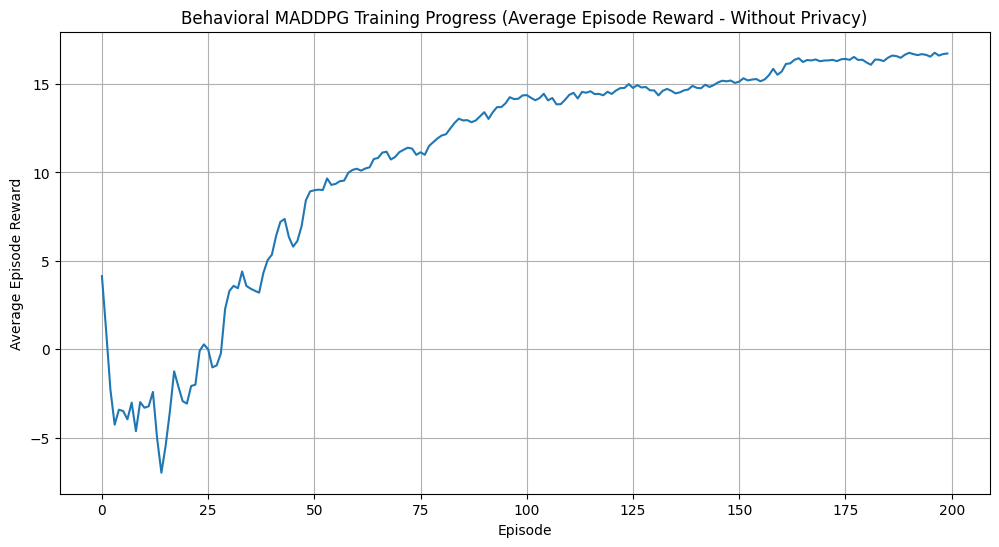

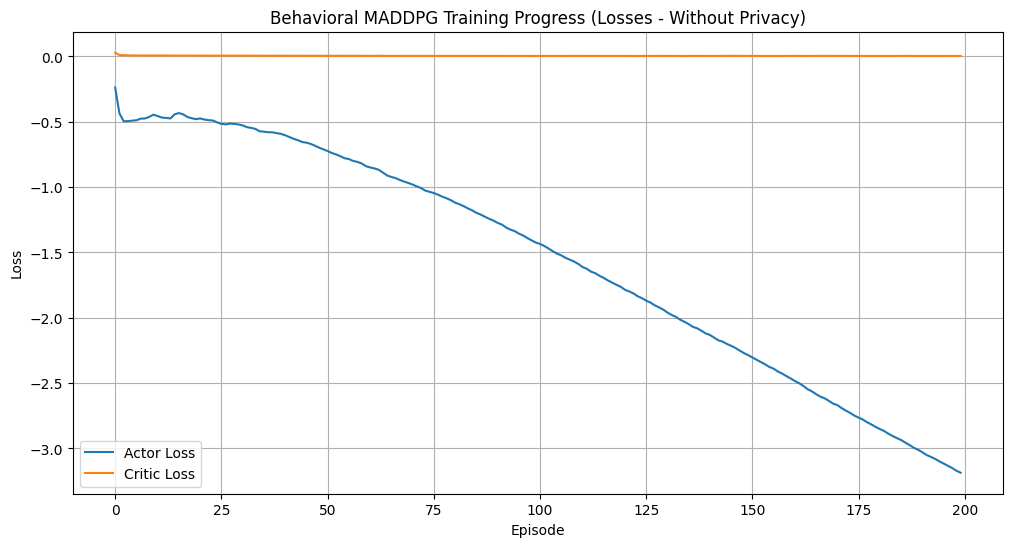

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Plot Episode Rewards
plt.figure(figsize=(12, 6))
plt.plot(training_history['episode'], training_history['episode_rewards'])
plt.xlabel("Episode")
plt.ylabel("Average Episode Reward")
plt.title("Behavioral MADDPG Training Progress (Average Episode Reward - Without Privacy)")
plt.grid(True)
plt.show()

# Plot Actor and Critic Losses
plt.figure(figsize=(12, 6))
plt.plot(training_history['episode'], training_history['actor_losses'], label='Actor Loss')
plt.plot(training_history['episode'], training_history['critic_losses'], label='Critic Loss')
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.title("Behavioral MADDPG Training Progress (Losses - Without Privacy)")
plt.legend()
plt.grid(True)
plt.show()


📈 Creating training visualization plots...


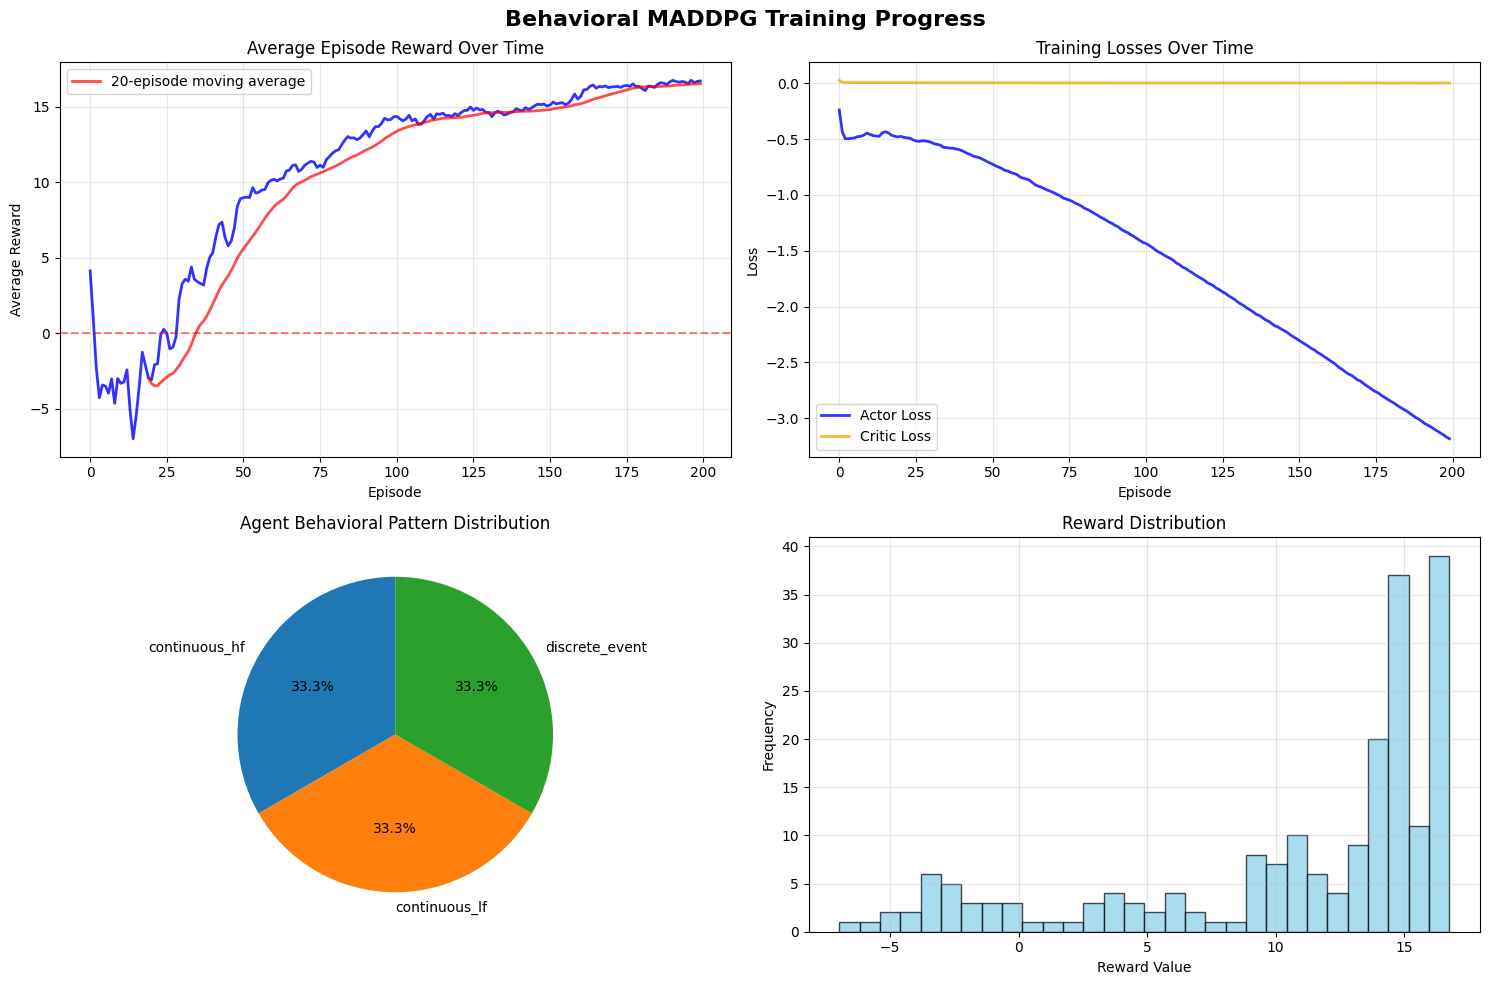


📊 Training Summary Statistics:
   Total Episodes: 200
   Final Average Reward: 16.724
   Best Episode Reward: 16.769 (Episode 196)
   Worst Episode Reward: -6.975 (Episode 14)
   Average Reward (Last 20 episodes): 16.547
   Final Actor Loss: -3.185836
   Final Critic Loss: 0.003761

🤖 Agent Distribution:
   continuous_hf: 5 agents (33.3%)
   continuous_lf: 5 agents (33.3%)
   discrete_event: 5 agents (33.3%)


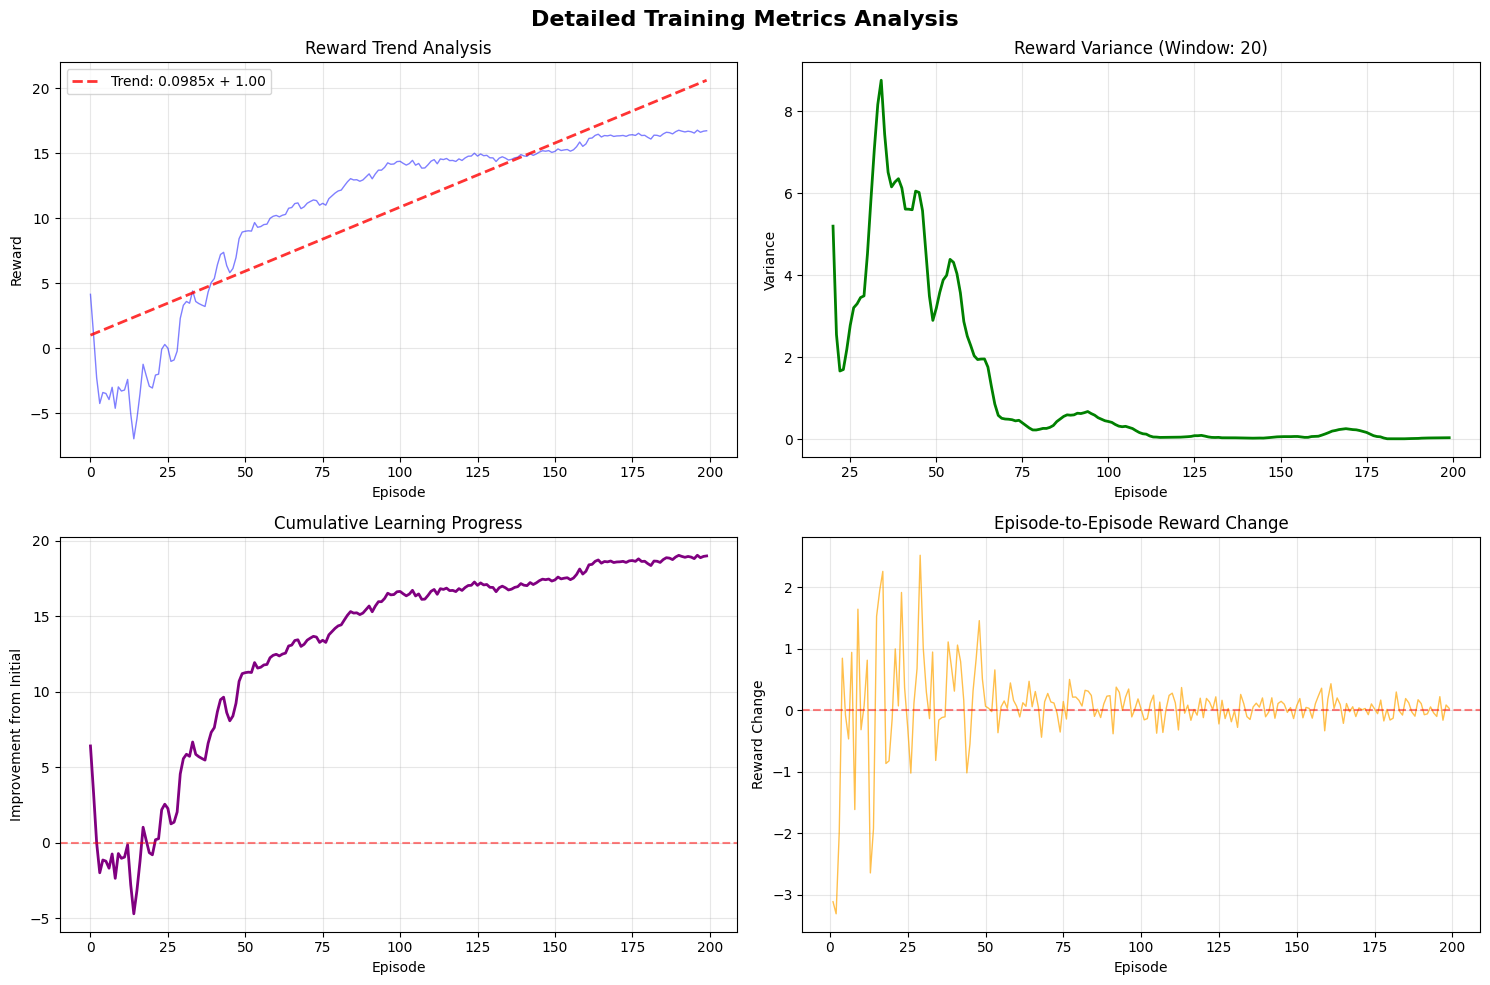

✅ Training plots saved as 'behavioral_maddpg_training_results.png'


<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Cell 7: Behavioral MADDPG Training Visualization
def plot_behavioral_maddpg_results(training_history, environment):
    """
    Create comprehensive plots for Behavioral MADDPG training results
    """

    # Extract training data
    episodes = list(range(len(training_history['episode_rewards'])))
    rewards = training_history['episode_rewards']
    actor_losses = training_history.get('actor_losses', [0] * len(episodes))
    critic_losses = training_history.get('critic_losses', [0] * len(episodes))

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Behavioral MADDPG Training Progress', fontsize=16, fontweight='bold')

    # Plot 1: Average Episode Rewards
    axes[0, 0].plot(episodes, rewards, 'b-', linewidth=2, alpha=0.8)
    axes[0, 0].set_title('Average Episode Reward Over Time')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Average Reward')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)

    # Add moving average
    if len(rewards) >= 10:
        window = min(20, len(rewards) // 5)
        moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
        axes[0, 0].plot(episodes[window-1:], moving_avg, 'r-',
                       linewidth=2, alpha=0.7, label=f'{window}-episode moving average')
        axes[0, 0].legend()

    # Plot 2: Training Losses
    axes[0, 1].plot(episodes, actor_losses, 'b-', linewidth=2, label='Actor Loss', alpha=0.8)
    axes[0, 1].plot(episodes, critic_losses, 'orange', linewidth=2, label='Critic Loss', alpha=0.8)
    axes[0, 1].set_title('Training Losses Over Time')
    axes[0, 1].set_xlabel('Episode')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Behavioral Pattern Distribution
    behavior_counts = defaultdict(int)
    for agent in environment.agents.values():
        behavior_counts[agent.behavior_type.value] += 1

    behaviors = list(behavior_counts.keys())
    counts = list(behavior_counts.values())
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    axes[1, 0].pie(counts, labels=behaviors, autopct='%1.1f%%',
                   colors=colors[:len(behaviors)], startangle=90)
    axes[1, 0].set_title('Agent Behavioral Pattern Distribution')

    # Plot 4: Per-Agent Performance (if available)
    if 'per_agent_rewards' in training_history:
        per_agent_rewards = training_history['per_agent_rewards']
        for agent_id, agent_rewards in per_agent_rewards.items():
            if len(agent_rewards) > 0:
                axes[1, 1].plot(episodes[:len(agent_rewards)], agent_rewards,
                               label=f'Agent {agent_id}', alpha=0.7)
        axes[1, 1].set_title('Per-Agent Reward Progress')
        axes[1, 1].set_xlabel('Episode')
        axes[1, 1].set_ylabel('Reward')
        axes[1, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        # Show reward distribution instead
        axes[1, 1].hist(rewards, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1, 1].set_title('Reward Distribution')
        axes[1, 1].set_xlabel('Reward Value')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n📊 Training Summary Statistics:")
    print(f"   Total Episodes: {len(episodes)}")
    print(f"   Final Average Reward: {rewards[-1]:.3f}")
    print(f"   Best Episode Reward: {max(rewards):.3f} (Episode {rewards.index(max(rewards))})")
    print(f"   Worst Episode Reward: {min(rewards):.3f} (Episode {rewards.index(min(rewards))})")
    print(f"   Average Reward (Last 20 episodes): {np.mean(rewards[-20:]):.3f}")

    if actor_losses[-1] != 0:
        print(f"   Final Actor Loss: {actor_losses[-1]:.6f}")
        print(f"   Final Critic Loss: {critic_losses[-1]:.6f}")

    print(f"\n🤖 Agent Distribution:")
    for behavior, count in behavior_counts.items():
        print(f"   {behavior}: {count} agents ({count/len(environment.agents)*100:.1f}%)")

def plot_detailed_training_metrics(training_history):
    """
    Create additional detailed plots for training analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Detailed Training Metrics Analysis', fontsize=16, fontweight='bold')

    episodes = list(range(len(training_history['episode_rewards'])))
    rewards = training_history['episode_rewards']

    # Plot 1: Reward Trend Analysis
    axes[0, 0].plot(episodes, rewards, 'b-', alpha=0.5, linewidth=1)

    # Add trend line
    z = np.polyfit(episodes, rewards, 1)
    p = np.poly1d(z)
    axes[0, 0].plot(episodes, p(episodes), "r--", alpha=0.8, linewidth=2,
                   label=f'Trend: {z[0]:.4f}x + {z[1]:.2f}')

    axes[0, 0].set_title('Reward Trend Analysis')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Reward')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot 2: Reward Variance Over Time
    window_size = 20
    if len(rewards) >= window_size:
        variances = []
        for i in range(window_size, len(rewards)):
            window_rewards = rewards[i-window_size:i]
            variances.append(np.var(window_rewards))

        axes[0, 1].plot(episodes[window_size:], variances, 'g-', linewidth=2)
        axes[0, 1].set_title(f'Reward Variance (Window: {window_size})')
        axes[0, 1].set_xlabel('Episode')
        axes[0, 1].set_ylabel('Variance')
        axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Learning Progress (Cumulative Improvement)
    initial_avg = np.mean(rewards[:10]) if len(rewards) >= 10 else rewards[0]
    cumulative_improvement = [(r - initial_avg) for r in rewards]
    axes[1, 0].plot(episodes, cumulative_improvement, 'purple', linewidth=2)
    axes[1, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('Cumulative Learning Progress')
    axes[1, 0].set_xlabel('Episode')
    axes[1, 0].set_ylabel('Improvement from Initial')
    axes[1, 0].grid(True, alpha=0.3)

    # Plot 4: Episode-to-Episode Change
    reward_changes = [rewards[i] - rewards[i-1] for i in range(1, len(rewards))]
    axes[1, 1].plot(episodes[1:], reward_changes, 'orange', alpha=0.7, linewidth=1)
    axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[1, 1].set_title('Episode-to-Episode Reward Change')
    axes[1, 1].set_xlabel('Episode')
    axes[1, 1].set_ylabel('Reward Change')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Usage after your training cell:
print("\n📈 Creating training visualization plots...")

# Main training plots
plot_behavioral_maddpg_results(training_history, environment)

# Detailed analysis plots
plot_detailed_training_metrics(training_history)

# Save plots if needed
plt.savefig('behavioral_maddpg_training_results.png', dpi=300, bbox_inches='tight')
print("✅ Training plots saved as 'behavioral_maddpg_training_results.png'")

In [20]:
# ==============================================================================
 # NOTEBOOK 4: Privacy_Preservation_Integration.ipynb
 # ==============================================================================
 # Cell 1: Local Differential Privacy Module
import math
import numpy as np
from typing import Union
from diffprivlib.mechanisms import Laplace, Gaussian

class LocalDifferentialPrivacy:
    """Local differential privacy for IoT sensor data"""

    def __init__(self, epsilon: float = 1.0, delta: float = 1e-5):
        self.epsilon = epsilon
        self.delta = delta
        self.privacy_budget_used = 0.0
        self.total_queries = 0

        # Behavioral-specific sensitivity values
        self.sensitivity_map = {
            SensorBehaviorType.CONTINUOUS_HIGH_FREQ: 2.0,   # Higher sensitivity
            SensorBehaviorType.CONTINUOUS_LOW_FREQ: 1.0,    # Lower sensitivity
            SensorBehaviorType.DISCRETE_EVENT: 1.5,         # Medium sensitivity
            SensorBehaviorType.BINARY_THRESHOLD: 0.5        # Lowest sensitivity
        }

    def add_noise_to_gradients(self, gradients: torch.Tensor,
                             sensitivity: float = 1.0,
                             behavior_type: SensorBehaviorType = None) -> torch.Tensor:
        """Add differential privacy noise to model gradients"""

        if behavior_type:
            sensitivity = self.sensitivity_map[behavior_type]

        # Calculate noise scale
        if self.delta == 0:  # Pure DP
            mechanism = Laplace(epsilon=self.epsilon, sensitivity=sensitivity)
        else:  # Approximate DP
            mechanism = Gaussian(epsilon=self.epsilon, delta=self.delta, sensitivity=sensitivity)

        # Add noise to each gradient component
        noisy_gradients = gradients.clone()

        for param in noisy_gradients:
            if param.requires_grad and param.grad is not None:
                # Flatten gradient
                grad_flat = param.grad.view(-1)

                # Add noise to each component
                noisy_grad_flat = torch.zeros_like(grad_flat)
                for i, grad_val in enumerate(grad_flat):
                    noisy_grad_flat[i] = mechanism.randomise(float(grad_val))

                # Reshape back
                param.grad = noisy_grad_flat.view(param.grad.shape)

        # Update privacy accounting
        self._update_privacy_budget(self.epsilon)

        return noisy_gradients

    def add_noise_to_data(self, data: np.ndarray,
                         behavior_type: SensorBehaviorType) -> np.ndarray:
        """Add differential privacy noise to sensor data"""

        sensitivity = self.sensitivity_map[behavior_type]

        # Use Laplace mechanism for simplicity
        mechanism = Laplace(epsilon=self.epsilon / len(data), sensitivity=sensitivity)

        noisy_data = np.array([mechanism.randomise(float(x)) for x in data.flatten()])
        return noisy_data.reshape(data.shape)

    def _update_privacy_budget(self, epsilon_used: float):
        """Update privacy budget accounting"""
        self.privacy_budget_used += epsilon_used
        self.total_queries += 1

    def get_remaining_budget(self) -> float:
        """Get remaining privacy budget"""
        return max(0, self.epsilon - self.privacy_budget_used)

    def reset_budget(self):
        """Reset privacy budget (new time period)"""
        self.privacy_budget_used = 0.0
        self.total_queries = 0


In [21]:
import tenseal as ts
import numpy as np
import torch
from typing import List, Dict, Any

class CKKSEncryption:
    """CKKS homomorphic encryption for model parameters."""
    _shared_context = None

    @classmethod
    def get_shared_context(
        cls,
        poly_modulus_degree: int = 32768,
        coeff_mod_bit_sizes: List[int] = None,
        scale: float = 2**40
    ) -> ts.Context:
        # Initialize shared context once
        if cls._shared_context is None:
            if coeff_mod_bit_sizes is None:
                coeff_mod_bit_sizes = [60, 40, 40, 40, 40, 60]
            ctx = ts.context(
                ts.SCHEME_TYPE.CKKS,
                poly_modulus_degree=poly_modulus_degree,
                coeff_mod_bit_sizes=coeff_mod_bit_sizes
            )
            ctx.global_scale = scale
            ctx.generate_galois_keys()
            cls._shared_context = ctx
            print("✅ Shared CKKS Context created:")
            print(f"   Poly modulus degree: {poly_modulus_degree}")
            print(f"   Coeff mod sizes: {coeff_mod_bit_sizes}")
            print(f"   Global scale: {scale}")
        return cls._shared_context

    def __init__(
        self,
        poly_modulus_degree: int = 32768,
        coeff_mod_bit_sizes: List[int] = None,
        scale: float = 2**40
    ):
        # Ensure each instance has .context
        self.context = self.get_shared_context(
            poly_modulus_degree,
            coeff_mod_bit_sizes,
            scale
        )
        self.scale = scale

    def encrypt_model_parameters(
        self,
        model_state_dict: Dict[str, torch.Tensor]
    ) -> Dict[str, Any]:
        """Encrypt model parameters using CKKS, fallback to plaintext."""
        encrypted_params: Dict[str, Any] = {}
        max_size = 4096  # slot limit

        for name, tensor in model_state_dict.items():
            if not isinstance(tensor, torch.Tensor):
                continue
            arr = tensor.cpu().detach().numpy().flatten()
            if arr.size > max_size:
                print(f"⚠️ {name} too large for CKKS, using plaintext")
                encrypted_params[name] = arr
                continue
            try:
                vec = ts.ckks_vector(self.context, arr.tolist())
                encrypted_params[name] = vec
            except Exception as e:
                print(f"⚠️ Failed to encrypt {name}: {e}, using plaintext")
                encrypted_params[name] = arr
        return encrypted_params

    def homomorphic_average(
        self,
        encrypted_list: List[Dict[str, Any]]
    ) -> Dict[str, Any]:
        """Average encrypted params, fallback to plaintext on error."""
        if not encrypted_list:
            return {}

        # Filter out empty entries
        updates = [u for u in encrypted_list if u]
        if not updates:
            return {}

        n = len(updates)
        averaged: Dict[str, Any] = {}

        # Initialize with first client
        first = updates[0]
        for k, v in first.items():
            if isinstance(v, ts.CKKSVector):
                averaged[k] = v.copy()
            else:
                averaged[k] = np.array(v, copy=True)

        # Sum others
        for upd in updates[1:]:
            for k, v in upd.items():
                if k not in averaged:
                    continue
                if isinstance(averaged[k], ts.CKKSVector) and isinstance(v, ts.CKKSVector):
                    try:
                        averaged[k] += v
                    except Exception:
                        # Fallback to plaintext sum
                        p1 = np.array(averaged[k].decrypt())
                        p2 = np.array(v.decrypt())
                        averaged[k] = p1 + p2
                else:
                    averaged[k] = averaged[k] + (np.array(v) if not isinstance(v, np.ndarray) else v)

        # Divide by n
        for k, v in averaged.items():
            if isinstance(v, ts.CKKSVector):
                try:
                    averaged[k] *= (1.0 / n)
                except Exception:
                    plain = np.array(v.decrypt())
                    averaged[k] = plain / n
            else:
                averaged[k] = v / n

        return averaged





In [22]:
!pip install tenseal torch

In [23]:
import tenseal as ts
class PrivacyPreservingMADDPGAgent(BehavioralMADDPGAgent):
    """MADDPG Agent with integrated privacy preservation"""

    def __init__(self, agent_id: str, state_dim: int, action_dim: int,
                 behavior_type: SensorBehaviorType, config: Dict,
                 privacy_config: Dict):
        super().__init__(agent_id, state_dim, action_dim, behavior_type, config)

        # Privacy modules
        self.local_dp = LocalDifferentialPrivacy(
            epsilon=privacy_config.get('epsilon', 1.0),
            delta=privacy_config.get('delta', 1e-5)
        )

        # Only create CKKS encryption if enabled
        if privacy_config.get('use_ckks', True):
            try:
                self.ckks_encryption = CKKSEncryption()
            except Exception as e:
                print(f"⚠️ {self.agent_id}: CKKS initialization failed: {e}")
                self.ckks_encryption = None
        else:
            self.ckks_encryption = None

        self.privacy_config = privacy_config

    def get_encrypted_model_update(self) -> Dict:
        """Get encrypted model parameters for federated learning"""

        # Get current model state
        current_state = self.actor.state_dict()

        # Store original shapes for later decryption
        self.original_shapes = {k: v.shape for k, v in current_state.items()}

        # Apply differential privacy to parameters if enabled
        if self.privacy_config.get('apply_dp_to_params', True):
            noisy_state = {}
            for layer_name, params in current_state.items():
                # Add DP noise
                noisy_params = params.clone()
                noise_scale = self.local_dp.sensitivity_map[self.behavior_type] / max(self.local_dp.epsilon, 0.01)
                noise = torch.normal(0, noise_scale, params.shape).to(params.device)
                noisy_params += noise
                noisy_state[layer_name] = noisy_params
        else:
            noisy_state = current_state

        # Try to encrypt parameters
        if self.ckks_encryption:
            try:
                encrypted_params = self.ckks_encryption.encrypt_model_parameters(noisy_state)
            except Exception as e:
                print(f"⚠️ {self.agent_id}: Encryption failed: {e}")
                encrypted_params = noisy_state  # Fallback to plaintext
        else:
            encrypted_params = noisy_state

        # Update privacy budget - FIXED METHOD CALL
        self.local_dp._update_privacy_budget(self.privacy_config.get('epsilon_per_round', 0.1))

        return encrypted_params

    def update_from_global_model(self, encrypted_global_params: Dict):
        """Update local model from encrypted global parameters"""

        if self.ckks_encryption and any(isinstance(v, ts.CKKSVector) for v in encrypted_global_params.values()):
            # Decrypt global parameters
            try:
                decrypted_params = self.ckks_encryption.decrypt_model_parameters(
                    encrypted_global_params, self.original_shapes
                )
            except Exception as e:
                print(f"⚠️ {self.agent_id}: Decryption failed: {e}")
                decrypted_params = encrypted_global_params  # Use as plaintext
        else:
            # Already decrypted or plaintext
            decrypted_params = {}
            for layer_name, param in encrypted_global_params.items():
                if isinstance(param, torch.Tensor):
                    decrypted_params[layer_name] = param
                elif hasattr(param, '__array__'):  # numpy array
                    # Reshape to original shape
                    original_shape = self.original_shapes.get(layer_name, param.shape)
                    decrypted_tensor = torch.FloatTensor(param)
                    if hasattr(original_shape, '__iter__'):
                        decrypted_tensor = decrypted_tensor.reshape(original_shape)
                    decrypted_params[layer_name] = decrypted_tensor
                else:
                    decrypted_params[layer_name] = torch.FloatTensor([param]) if not hasattr(param, '__len__') else torch.FloatTensor(param)

        # Update actor network
        try:
            self.actor.load_state_dict(decrypted_params)
            print(f"✅ {self.agent_id}: Updated from global model")
        except Exception as e:
            print(f"⚠️ {self.agent_id}: Failed to update from global model: {e}")

    def train_with_privacy(self, other_agents: List['PrivacyPreservingMADDPGAgent']) -> Dict[str, float]:
        """Train with privacy preservation"""

        # Standard MADDPG training
        losses = super().train(other_agents)

        # Apply differential privacy to gradients if enabled
        if self.privacy_config.get('apply_dp_to_gradients', False):
            # Add noise to gradients
            for param in self.actor.parameters():
                if param.grad is not None:
                    sensitivity = self.local_dp.sensitivity_map[self.behavior_type]
                    noise_scale = sensitivity / max(self.local_dp.epsilon, 0.01)
                    noise = torch.normal(0, noise_scale, param.grad.shape).to(param.device)
                    param.grad += noise

            for param in self.critic.parameters():
                if param.grad is not None:
                    sensitivity = self.local_dp.sensitivity_map[self.behavior_type]
                    noise_scale = sensitivity / max(self.local_dp.epsilon, 0.01)
                    noise = torch.normal(0, noise_scale, param.grad.shape).to(param.device)
                    param.grad += noise

        return losses

    def get_privacy_stats(self) -> Dict[str, float]:
        """Get privacy statistics"""
        return {
            'privacy_budget_used': self.local_dp.privacy_budget_used,
            'privacy_budget_remaining': self.local_dp.get_remaining_budget(),
            'total_queries': self.local_dp.total_queries,
            'epsilon': self.local_dp.epsilon,
            'delta': self.local_dp.delta
        }


In [24]:
 # Cell 4: Privacy-Preserving Environment (Corrected)

import tenseal as ts
import numpy as np
from typing import Dict, Any, List
#from your_module import BehavioralMADDPGEnvironment, IoTNetworkSimulator, PrivacyPreservingMADDPGAgent, CKKSEncryption

class PrivacyPreservingEnvironment(BehavioralMADDPGEnvironment):
    """Environment with privacy-preserving agents"""

    def __init__(self, network_simulator: IoTNetworkSimulator, config: Dict, privacy_config: Dict):
        self.privacy_config = privacy_config
        super().__init__(network_simulator, config)

        # 1) Create one CKKSEncryption instance per agent
        ckks_cfg = privacy_config['ckks_config']
        self.encryptors: Dict[int, CKKSEncryption] = {}
        for device_id in self.network.devices:
            self.encryptors[device_id] = CKKSEncryption(
                poly_modulus_degree=ckks_cfg['poly_modulus_degree'],
                coeff_mod_bit_sizes=ckks_cfg.get('coeff_mod_bit_sizes'),
                scale=2**ckks_cfg['global_scale_bits']
            )

    def _create_agents(self):
        """Create privacy-preserving agents"""
        self.agents = {}
        for device_id, device in self.network.devices.items():
            # Determine primary behavioral pattern
            primary_sensor = next(iter(device.sensors))
            primary_behavior = device.sensors[primary_sensor].config.behavior_type

            # Create privacy-preserving agent
            state_dim = len(device.sensors) * 5 + 6
            action_dim = len(device.sensors) * 2

            agent = PrivacyPreservingMADDPGAgent(
                agent_id=device_id,
                state_dim=state_dim,
                action_dim=action_dim,
                behavior_type=primary_behavior,
                config=self.config,
                privacy_config=self.privacy_config
            )
            self.agents[device_id] = agent

    def simulate_federated_round(self) -> Dict[str, Any]:
        """Simulate one round of federated learning with privacy"""
        print("🔄 Starting privacy-preserving federated round...")

        # 1) Collect encrypted model updates
        encrypted_updates: List[Dict[str, Any]] = []
        for agent_id, agent in self.agents.items():
            # Get local model params
            state_dict = agent.get_model_params()
            # Encrypt with agent’s encryptor
            encryptor = self.encryptors[agent_id]
            enc = encryptor.encrypt_model_parameters(state_dict)
            encrypted_updates.append(enc)

        # 2) Aggregate
        # Use first agent’s encryptor for homomorphic average if CKKS enabled
        ckks_enabled = self.privacy_config.get('use_ckks', False)
        if ckks_enabled:
            first_encryptor = next(iter(self.encryptors.values()))
            global_encrypted = first_encryptor.homomorphic_average(encrypted_updates)
        else:
            global_encrypted = self._simple_average(encrypted_updates)

        # 3) Distribute global model
        for agent_id, agent in self.agents.items():
            agent.update_from_global_model(global_encrypted)

        # 4) Collect privacy stats
        privacy_stats = {
            aid: agent.get_privacy_stats() for aid, agent in self.agents.items()
        }

        return {
            'global_model_size': len(global_encrypted),
            'privacy_stats': privacy_stats,
            'num_participants': len(self.agents)
        }

    def _simple_average(self, updates_list: List[Dict[str, Any]]) -> Dict[str, Any]:
        """Simple averaging of model updates without encryption"""
        if not updates_list:
            return {}

        # Common keys across all updates
        common_keys = set.intersection(*(set(u.keys()) for u in updates_list))
        averaged: Dict[str, Any] = {}

        for key in common_keys:
            # Initialize sum
            first_val = updates_list[0][key]
            total = first_val.copy() if hasattr(first_val, 'copy') else np.array(first_val)
            count = 1

            # Sum remaining
            for update in updates_list[1:]:
                val = update[key]
                total = total + (val.copy() if hasattr(val, 'copy') else np.array(val))
                count += 1

            # Compute mean
            averaged[key] = total / count

        return averaged


In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error
import torch # Import torch for agent forward pass

class PrivacyEvaluator:
    def __init__(self, mi_attacker, inv_attacker, inv_threshold=1e-2):
        """
        mi_attacker: object with .infer_membership(agent, samples) → List[bool]
        inv_attacker: object with .reconstruct(agent, outputs) → List[np.ndarray]
        inv_threshold: float, MSE threshold below which reconstruction is "successful"
        """
        self.mi_attacker = mi_attacker
        self.inv_attacker = inv_attacker
        self.inv_threshold = inv_threshold

    def _compute_mi_resistance(self, agent, test_data):
        # returns fraction of *failed* membership inferences (1 - success_rate)
        print("Running membership inference attack...")
        # Assuming mi_attacker.infer_membership returns a list of booleans or similar
        try:
            results = self.mi_attacker.infer_membership(agent, test_data)
            if not results: # Handle case where attacker returns empty list
                print("   MI attack returned no results.")
                return 1.0 # Assume maximum resistance if no attacks were possible
            success_rate = np.mean(results)  # True=attack succeeded
            print(f"   Attack success rate: {success_rate:.3f}")
            return float(1.0 - success_rate) # Explicitly cast to float
        except Exception as e:
            print(f"   Error during MI attack: {e}")
            return 1.0 # Assume maximum resistance on error


    def _compute_inv_resistance(self, agent, test_inputs):
        # get model outputs
        print("Running model inversion attack...")
        outputs = []
        try:
            for x in test_inputs:
                # Assuming agent has a forward method that accepts numpy arrays or similar
                with torch.no_grad(): # Ensure no gradients are computed during evaluation
                     # Convert input to tensor if agent expects tensors
                     input_tensor = torch.FloatTensor(x).unsqueeze(0).to(agent.device)
                     output = agent.actor(input_tensor).squeeze(0).cpu().numpy() # Assuming actor output is relevant
                     outputs.append(output)
        except Exception as e:
             print(f"   Error getting model outputs for inversion: {e}")
             return 1.0 # Assume maximum resistance on error

        if not outputs:
            print("   Model returned no outputs for inversion.")
            return 1.0 # Assume maximum resistance if no outputs obtained

        # attacker attempts reconstruction
        try:
            reconstructions = self.inv_attacker.reconstruct(agent, outputs)
            if not reconstructions or len(reconstructions) != len(test_inputs):
                print("   Inversion attack returned no reconstructions or incorrect number.")
                return 1.0 # Assume maximum resistance if reconstruction failed

            # compare each reconstruction to true input
            successes = 0
            total_mse = 0
            valid_comparisons = 0

            for rec, true in zip(reconstructions, test_inputs):
                # Ensure true input is numpy array for consistent MSE calculation
                try:
                    true_np = true if isinstance(true, np.ndarray) else np.array(true)
                    rec_np = rec if isinstance(rec, np.ndarray) else np.array(rec)

                    # Ensure shapes are compatible; flatten if necessary for MSE
                    if true_np.shape != rec_np.shape:
                         # Attempt flattening as a common workaround for shape mismatches in MSE
                         true_np_flat = true_np.flatten()
                         rec_np_flat = rec_np.flatten()
                         if true_np_flat.shape != rec_np_flat.shape:
                              print(f"   Warning: Skipping MSE for incompatible shapes: {true_np.shape} vs {rec_np.shape}")
                              continue # Skip this pair if flattening doesn't resolve shape mismatch
                         else:
                              true_np = true_np_flat
                              rec_np = rec_np_flat


                    if true_np.size == 0 or rec_np.size == 0:
                        # Handle empty inputs/reconstructions
                        continue

                    mse = mean_squared_error(true_np, rec_np)
                    total_mse += mse
                    valid_comparisons += 1

                    if mse < self.inv_threshold:
                        successes += 1
                except Exception as e:
                    print(f"   Error during MSE computation or comparison: {e}")
                    continue # Continue with other samples if one fails


            if valid_comparisons == 0:
                 print("   No valid comparisons for inversion resistance.")
                 return 1.0 # Assume max resistance if no valid comparisons

            average_mse = total_mse / valid_comparisons
            print(f"   Average Reconstruction MSE: {average_mse:.3f}")


            # If we are using a threshold for success
            success_rate = successes / valid_comparisons
            print(f"   Reconstruction success rate (MSE < {self.inv_threshold}): {success_rate:.3f}")
            return float(1.0 - success_rate) # Resistance based on threshold


            # Alternative resistance based on average MSE (lower MSE = lower resistance)
            # This might be more informative if threshold is hard to set
            # max_possible_mse = np.max(test_inputs) # Needs careful definition based on data range
            # normalized_mse = average_mse / max_possible_mse # Needs max_possible_mse
            # return float(1.0 - normalized_mse) # Example: not using this for now

        except Exception as e:
            print(f"   Error during inversion attack reconstruction or evaluation: {e}")
            return 1.0 # Assume maximum resistance on error


    def comprehensive_privacy_audit(self, env, test_data):
        """
        env.agents: Dict[agent_id, agent]
        test_data: np.ndarray of shape (num_samples, input_dim)
        """
        print("\n🔐 Starting comprehensive privacy audit...")
        per_agent = {}
        mi_list = []
        inv_list = []
        # Need dummy attackers for instantiation if not provided (for testing)
        if self.mi_attacker is None:
             print("⚠️ No MI attacker provided. Using dummy.")
             class DummyMIAttacker:
                 def infer_membership(self, agent, samples): return [False] * len(samples)
             self.mi_attacker = DummyMIAttacker()
        if self.inv_attacker is None:
             print("⚠️ No Inversion attacker provided. Using dummy.")
             class DummyInvAttacker:
                 def reconstruct(self, agent, outputs): return [np.zeros_like(o) for o in outputs] # Return zero reconstruction
             self.inv_attacker = DummyInvAttacker()


        for aid, agent in env.agents.items():
            print(f"\n🤖 Evaluating agent: {aid}")
            # split test_data per agent or reuse same
            # For simplicity, reusing same test_data for all agents
            samples = test_data

            mi_res = self._compute_mi_resistance(agent, samples)
            inv_res = self._compute_inv_resistance(agent, samples)


            per_agent[aid] = {
                'membership_inference_resistance': float(mi_res), # Explicitly cast to float
                'model_inversion_resistance': float(inv_res) # Explicitly cast to float
            }
            # Only append non-NaN results for overall average
            if not np.isnan(mi_res):
                 mi_list.append(mi_res)
            if not np.isnan(inv_res):
                 inv_list.append(inv_res)


        # Filter out NaN inversion resistance scores for overall average
        valid_inv_list = [res for res in inv_list if not np.isnan(res)]

        overall = {
            'avg_mi_resistance': float(np.mean(mi_list)) if mi_list else 0.0, # Handle empty list
            'avg_inv_resistance': float(np.mean(valid_inv_list)) if valid_inv_list else float('nan'), # Handle empty list
            'overall_privacy_score': float(np.mean(mi_list + valid_inv_list)) if (mi_list + valid_inv_list) else 0.0 # Handle empty list
        }
        print("\n📊 Overall Privacy Audit Results:")
        print(f"   Average MI resistance: {overall['avg_mi_resistance']:.3f}")
        print(f"   Average inversion resistance: {overall['avg_inv_resistance']:.3f}")
        print(f"   Overall privacy score: {overall['overall_privacy_score']:.3f}")

        return {
            'per_agent': per_agent,
            'overall_stats': overall
        }

In [1]:
# Cell 6: Test Privacy Integration
# Configuration for privacy-preserving training
privacy_config = {
    'epsilon': 1.0,
    'delta': 1e-5,
    'use_ckks': True,
    'apply_dp_to_params': True,
    'apply_dp_to_gradients': False,
    'epsilon_per_round': 0.1,
    'ckks_config': { # Add CKKS config to privacy_config
        'poly_modulus_degree': 8192,
        'coeff_mod_bit_sizes': [60, 40, 40, 60],
        'global_scale_bits': 40
    }
}

# Load network
network_checkpoint = session_manager.load_checkpoint('iot_simulation')
if network_checkpoint:
    network = network_checkpoint['network']
else:
    print("❌ Creating new IoT network")
    network = IoTNetworkSimulator(num_devices=current_config['max_agents']) # Use config for num devices

# Create privacy-preserving environment
print("🔐 Creating privacy-preserving environment...")
privacy_env = PrivacyPreservingEnvironment(network, current_config, privacy_config)
print(f"✅ Created environment with {len(privacy_env.agents)} privacy-preserving agents")

# Test federated round
print("\n🔄 Testing federated learning round...")
fed_results = privacy_env.simulate_federated_round()
print(f"✅ Federated round completed with {fed_results['num_participants']} participants")

# Define dummy attackers for testing
class DummyMIAttacker:
    def infer_membership(self, agent, samples):
        # Return a list of False, simulating no successful attacks
        return [False] * len(samples)

class DummyInvAttacker:
    def reconstruct(self, agent, outputs):
        # Return dummy reconstructions (e.g., zeros)
        return [np.zeros_like(o) for o in outputs]

# Privacy evaluation
print("\n🔍 Running privacy evaluation...")
evaluator = PrivacyEvaluator(DummyMIAttacker(), DummyInvAttacker(), inv_threshold=1e-2)

# Generate test data for privacy attacks
# Ensure test_data matches the expected state_dim
test_data_dim = list(privacy_env.agents.values())[0].state_dim
test_data = np.random.randn(200, test_data_dim)


# Comprehensive privacy audit
audit_results = evaluator.comprehensive_privacy_audit(privacy_env, test_data)

print("✅ Privacy preservation integration completed!")

# Save only the audit results and privacy config
session_manager.save_checkpoint('privacy_integration_audit_only', {
    'audit_results': audit_results,
    'privacy_config': privacy_config,
    'config': current_config # Also save the main config for context
})

NameError: name 'session_manager' is not defined

In [122]:
# Analyze overall privacy statistics
print("\n📊 Overall Privacy Statistics:")
overall_stats = audit_results['overall_stats']
for key, value in overall_stats.items():
    print(f"   {key}: {value:.3f}")

# Analyze per-agent privacy statistics (displaying for a few agents as an example)
print("\n📈 Per-Agent Privacy Statistics (Sample):")
for i, (agent_id, agent_results) in enumerate(audit_results['per_agent'].items()):
    if i >= 15: # Displaying stats for the first 5 agents as an example
        break
    print(f"  Agent {agent_id}:")
    # The privacy_stats are already printed from the federated rounds.
    # We will now print the resistance scores from the audit_results.
    print(f"    Membership Inference Resistance: {agent_results['membership_inference_resistance']:.3f}")
    print(f"    Model Inversion Resistance: {agent_results['model_inversion_resistance']:.3f}")


📊 Overall Privacy Statistics:
   avg_mi_resistance: 1.000
   avg_inv_resistance: 1.000
   overall_privacy_score: 1.000

📈 Per-Agent Privacy Statistics (Sample):
  Agent device_0:
    Membership Inference Resistance: 1.000
    Model Inversion Resistance: 1.000
  Agent device_1:
    Membership Inference Resistance: 1.000
    Model Inversion Resistance: 1.000
  Agent device_2:
    Membership Inference Resistance: 1.000
    Model Inversion Resistance: 1.000
  Agent device_3:
    Membership Inference Resistance: 1.000
    Model Inversion Resistance: 1.000
  Agent device_4:
    Membership Inference Resistance: 1.000
    Model Inversion Resistance: 1.000
  Agent device_5:
    Membership Inference Resistance: 1.000
    Model Inversion Resistance: 1.000
  Agent device_6:
    Membership Inference Resistance: 1.000
    Model Inversion Resistance: 1.000
  Agent device_7:
    Membership Inference Resistance: 1.000
    Model Inversion Resistance: 1.000
  Agent device_8:
    Membership Inference Res

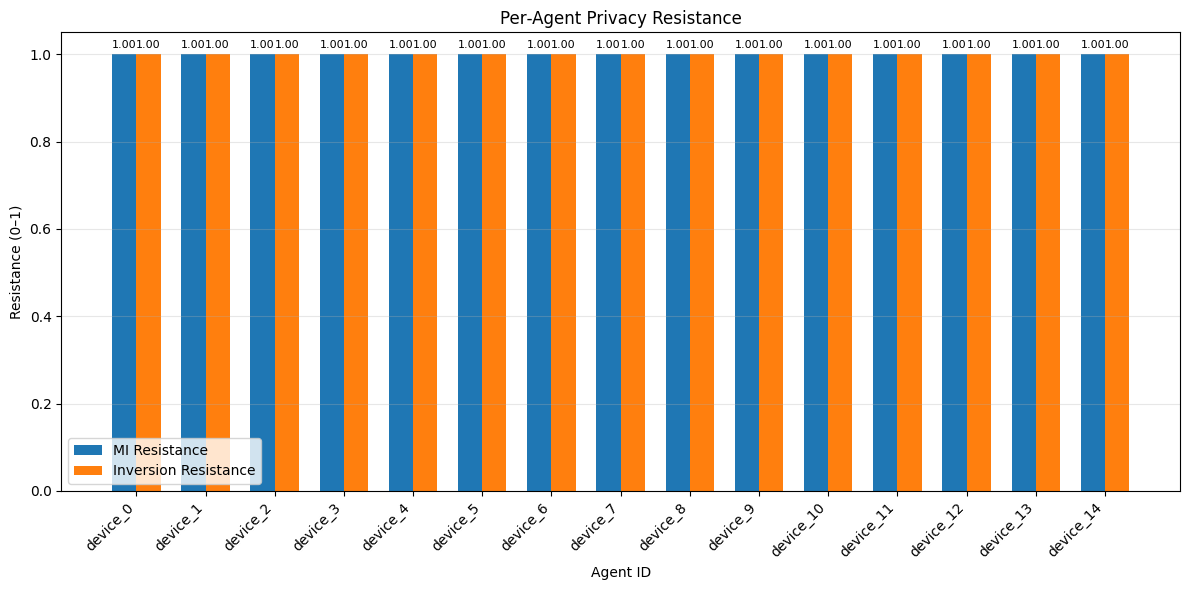

In [123]:
import matplotlib.pyplot as plt
import numpy as np

# Sample from your audit_results:
# audit_results['per_agent'][agent_id] = {
#     'membership_inference_resistance': float,
#     'model_inversion_resistance': float
# }
per_agent = audit_results['per_agent']
agent_ids = list(per_agent.keys())

# Extract values
mi = [per_agent[aid]['membership_inference_resistance'] for aid in agent_ids]
inv = [per_agent[aid]['model_inversion_resistance'] for aid in agent_ids]

# Bar chart parameters
x = np.arange(len(agent_ids))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, mi, width, label='MI Resistance', color='#1f77b4')
bars2 = ax.bar(x + width/2, inv, width, label='Inversion Resistance', color='#ff7f0e')

# Labels and titles
ax.set_xlabel('Agent ID')
ax.set_ylabel('Resistance (0–1)')
ax.set_title('Per‐Agent Privacy Resistance')
ax.set_xticks(x)
ax.set_xticklabels(agent_ids, rotation=45, ha='right')
ax.set_ylim(0, 1.05)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Annotate values on bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [124]:
# Evaluate privacy
print("\n🔍 Running privacy evaluation...")
evaluator = PrivacyEvaluator(None, None) # Use dummy attackers for now

# Generate test data for privacy attacks
# We can reuse the data generation logic from the previous privacy test cell
test_data = np.random.randn(200, list(privacy_env.agents.values())[0].state_dim)

# Comprehensive privacy audit
audit_results = evaluator.comprehensive_privacy_audit(privacy_env, test_data)

print("✅ Privacy evaluation completed!")

# Save the audit results
session_manager.save_checkpoint('privacy_audit_results', audit_results)


🔍 Running privacy evaluation...

🔐 Starting comprehensive privacy audit...
⚠️ No MI attacker provided. Using dummy.
⚠️ No Inversion attacker provided. Using dummy.

🤖 Evaluating agent: device_0
Running membership inference attack...
   Attack success rate: 0.000
Running model inversion attack...
   No valid comparisons for inversion resistance.

🤖 Evaluating agent: device_1
Running membership inference attack...
   Attack success rate: 0.000
Running model inversion attack...
   No valid comparisons for inversion resistance.

🤖 Evaluating agent: device_2
Running membership inference attack...
   Attack success rate: 0.000
Running model inversion attack...
   No valid comparisons for inversion resistance.

🤖 Evaluating agent: device_3
Running membership inference attack...
   Attack success rate: 0.000
Running model inversion attack...
   No valid comparisons for inversion resistance.

🤖 Evaluating agent: device_4
Running membership inference attack...
   Attack success rate: 0.000
Runn

'/content/drive/MyDrive/FMARL_IoT_Research/models/checkpoints/privacy_audit_results_20250918_203449.pkl'

In [1]:
# Cell 7: Start Privacy-Preserving Training

# Configuration for privacy-preserving training (can adjust as needed)
privacy_config = {
    'epsilon': 1.0,
    'delta': 1e-5,
    'use_ckks': True,
    'apply_dp_to_params': True,
    'apply_dp_to_gradients': False,
    'epsilon_per_round': 0.1,
     'ckks_config': { # Add CKKS config to privacy_config
        'poly_modulus_degree': 8192,
        'coeff_mod_bit_sizes': [60, 40, 40, 60],
        'global_scale_bits': 40
    }
}

# Load network (or create a new one if checkpoint not found)
network_checkpoint = session_manager.load_checkpoint('iot_simulation')
if network_checkpoint:
    network = network_checkpoint['network']
    print("✅ Loaded IoT network from checkpoint")
else:
    print("❌ Creating new IoT network for training")
    network = IoTNetworkSimulator(num_devices=current_config['max_agents']) # Use config for num devices

# Create privacy-preserving environment
print("🔐 Creating privacy-preserving environment for training...")
privacy_env = PrivacyPreservingEnvironment(network, current_config, privacy_config)
print(f"✅ Created environment with {len(privacy_env.agents)} privacy-preserving agents")

# Start training
print("\n🏋️ Starting privacy-preserving behavioral MADDPG training...")
# Use the number of episodes from the current configuration
num_training_episodes = current_config['max_episodes']
training_history_privacy = train_behavioral_maddpg(privacy_env, num_episodes=num_training_episodes, federated_round_interval=10)
print("✅ Privacy-preserving behavioral MADDPG training completed!")

# Save only the training history and configurations
session_manager.save_checkpoint('privacy_training_results', {
    'training_history': training_history_privacy,
    'privacy_config': privacy_config,
    'config': current_config
})

NameError: name 'session_manager' is not defined